# Система уравнений Лотки-Вольтерры

Система уравнений Лотки-Вольтерры описывает динамику взаимодействия между двумя видами: хищниками и их жертвами. Уравнения имеют следующий вид:

\begin{cases}
\frac{dx}{dt} = \alpha x - \beta x y \\
\frac{dy}{dt} = -\gamma y + \delta x y
\end{cases}

## Коэффициенты и начальные условия

Для данной системы уравнений заданы следующие коэффициенты и начальные условия:

- **α = 0.8** — коэффициент роста жертв в отсутствие хищников;
- **β = 0.1** — коэффициент взаимодействия хищник-жертва, определяющий убыль жертв в результате встречи с хищниками;
- **γ = 1.5** — коэффициент смерти хищников в отсутствие жертв;
- **δ = 0.1** — коэффициент роста хищников за счет потребления жертв;
- **x₀ = 10** — начальное количество жертв;
- **y₀ = 10** — начальное количество хищников.

Коэффициенты и начальные условия выбраны так, чтобы решения x(t) и y(t) были переодическими.
Найдем численное решение задачи используя метод Рунге-Кутты

In [ ]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

constants = {
    "alpha": 1.0,  # коэффициент роста жертв
    "beta": 0.1,  # коэффициент взаимодействия хищник-жертва
    "gamma": 1.5,  # коэффициент смерти хищников
    "delta": 0.1,  # коэффициент роста хищников за счет жертв
}

start = {  # начальные условия
    "x0": 10.0,
    "y0": 10.0
}

t_span = [0.0, 20.0]  # интервал интегрирования
n_points = 2000
t_eval = np.linspace(t_span[0], t_span[1], n_points)

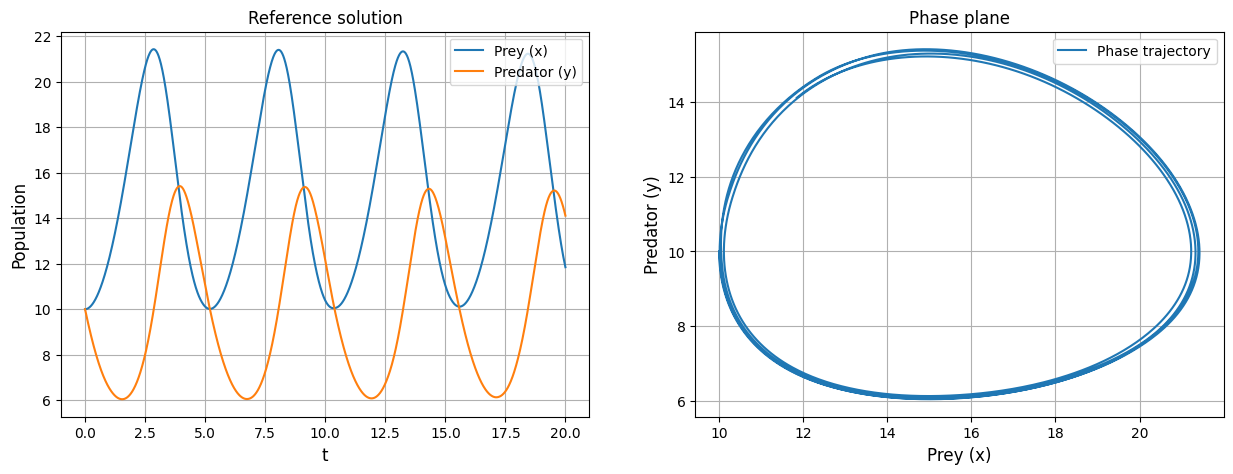

In [ ]:
# System of Lotka-Volterra equations
def lotka_volterra(t, xy, alpha, beta, gamma, delta):
    x, y = xy
    dxdt = alpha * x - beta * x * y
    dydt = -gamma * y + delta * x * y
    return [dxdt, dydt]

# Solve the system using RK45
def solve_system(constants, start, t_span, t_eval):
    sol = solve_ivp(lambda t, xy: lotka_volterra(t, xy, constants['alpha'],
                                                 constants['beta'],
                                                 constants['gamma'],
                                                 constants['delta']),
                    t_span, [start['x0'], start['y0']], t_eval=t_eval, method='RK45')
    return sol.t, sol.y

t_ref, data_ref = solve_system(constants, start, t_span, t_eval)
x_ref, y_ref = data_ref


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Solution
ax1.set_title('Reference solution')
ax1.plot(t_ref, x_ref, label="Prey (x)")
ax1.plot(t_ref, y_ref, label="Predator (y)")
ax1.set_xlabel('t', size=12)
ax1.set_ylabel('Population', size=12)
ax1.legend()
ax1.grid()

# Phase plane
ax2.set_title('Phase plane')
ax2.plot(x_ref, y_ref, label="Phase trajectory")
ax2.set_xlabel('Prey (x)', size=12)
ax2.set_ylabel('Predator (y)', size=12)
ax2.legend()
ax2.grid()

Мы убедились, что это решения действительно периодичны, в дальнейшем будем рассматривать t в промежутке [0,5] для уменьшения времени обучения моделей.

In [ ]:
x_ref, y_ref, t_ref = x_ref[:500], y_ref[:500], t_ref[:500]
# Установка устройства для вычислений (CPU или GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Определение области определения
t_min, t_max = 0.0, 5.0

# Количество точек внутри области и на границе
num_interior = 499   # Внутренние точки
num_boundary = 1     # Граничные точки

# Генерация сетки от x_min до x_max с количеством точек num_interior+num_boundary
t = torch.linspace(t_min, t_max, num_interior+num_boundary).view(-1, 1).to(device)

# Создание маски для внутренних точек
mask = torch.zeros_like(t, dtype = bool)

# Маркирование внутренних точек
mask[num_boundary:] = True

# Внутренние точки
t_interior = t[mask].view(-1, 1).requires_grad_(True)

# Граничные точки
t_boundary = t[~mask].view(-1, 1)

In [ ]:
# Определение нейронной сети
class MySin(nn.Module):
    def __init__(self):
        super(MySin, self).__init__()

    def forward(self, x):
        return torch.sin(x)

class PINN(nn.Module):
    def __init__(self, activation_func, num_of_neurons, num_of_layers=3):
        super(PINN, self).__init__()
        act_f = activation_func
        n = num_of_neurons
        layers = [nn.Linear(1, n), act_f()]
        for _ in range(num_of_layers - 1):
            layers.append(nn.Linear(n, n))
            layers.append(act_f())
        layers.append(nn.Linear(n, 2))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [ ]:
# Определение функции потерь
def loss_function(t_interior, t_boundary, x_boundary, y_boundary, lambda_bc=1.0):
    # Предсказания модели на внутренних точках
    output_interior = model(t_interior)
    x_interior = output_interior[:, 0].unsqueeze(1)
    y_interior = output_interior[:, 1].unsqueeze(1)

    # Вычисление производной dy/dx с помощью автоматического дифференцирования
    dy_dt = torch.autograd.grad(
        y_interior, t_interior,
        grad_outputs=torch.ones_like(y_interior),
        create_graph=True
    )[0]
    dx_dt = torch.autograd.grad(
        x_interior, t_interior,
        grad_outputs=torch.ones_like(x_interior),
        create_graph=True
    )[0]

    # Вычисление функции дифференциального уравнения на внутренних точках (residual)
    residual_x = dx_dt - (constants['alpha'] * x_interior - constants['beta'] * x_interior * y_interior)
    residual_y = dy_dt - (constants['delta'] * x_interior * y_interior - constants['gamma'] * y_interior)

    # Предсказания модели на граничных точках
    output_boundary = model(t_boundary)
    yb_pred = output_boundary[:, 1]
    xb_pred = output_boundary[:, 0]

    # Потери на уравнении (MSE по residual)
    loss_interior = torch.mean(residual_y**2 + residual_x**2)

    # Потери на граничных условиях (MSE между предсказанием и истинным значением)
    loss_boundary = torch.mean((yb_pred - y_boundary)**2 + (xb_pred - x_boundary)**2)

    # Общая функция потерь с учетом коэффициента lambda_bc
    loss = loss_interior + lambda_bc * loss_boundary
    return loss

# Параметры обучения:
num_epochs = 10000
lambda_bc = 1.0
num_of_neurons = 32
num_of_layers = 4

# Граничные условия
x_boundary = torch.tensor([[10.0]], requires_grad=True).to(device)
y_boundary = torch.tensor([[10.0]], requires_grad=True).to(device)

# Models
activation_functions = [MySin, nn.Tanh, nn.Sigmoid, nn.Softplus]
loss_of_act = []
pred_funcs = []
errors = []

# Цикл обучения с использованием tqdm
for activation_function in activation_functions:

  pbar = tqdm(range(num_epochs), desc='Training', ncols=80)
  model = PINN(activation_function, num_of_neurons, num_of_layers).to(device)
  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  loss_history = []

  for epoch in pbar:
      optimizer.zero_grad()
      loss = loss_function(t_interior, t_boundary, x_boundary, y_boundary, lambda_bc)
      loss.backward()
      optimizer.step()
      loss_history.append(loss.item())
      # Обновление отображения tqdm
      pbar.set_postfix({'Loss': f'{loss.item():.3e}'})

  #Добавление loss в общий список
  loss_of_act.append(loss_history)

  # Формируем данные для отрисовки
  t_plot = t.cpu().detach().numpy()
  pred = model(t).cpu().detach().numpy()
  x_pred = pred[:,0]
  y_pred = pred[:,1]
  pred_funcs.append([x_pred, y_pred])

  absolute_error_x = np.abs(x_ref - x_pred)
  absolute_error_y = np.abs(y_ref - y_pred)
  errors.append([absolute_error_x, absolute_error_y])

Training: 100%|███████████| 10000/10000 [02:04<00:00, 80.52it/s, Loss=1.955e-03]


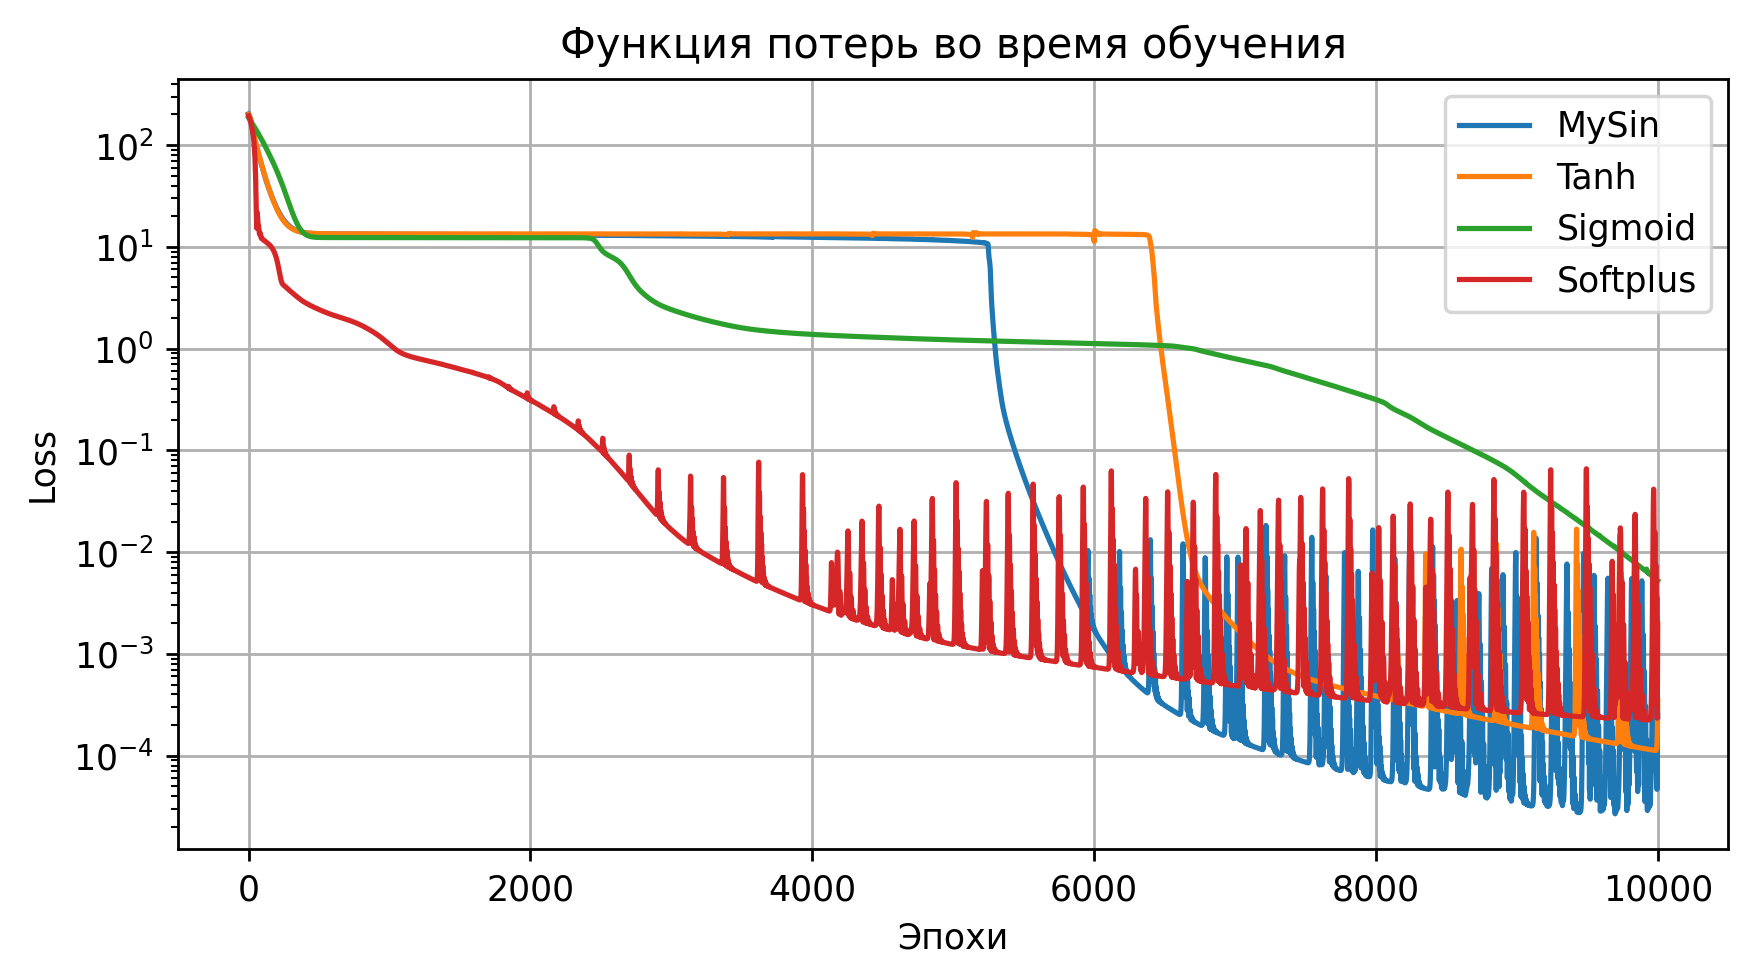

In [ ]:
# Построение графика функции потерь в логарифмическом масштабе
plt.figure(figsize=(8, 4), dpi=250)
for i in range(len(loss_of_act)):
  plt.plot(loss_of_act[i], label=str(activation_functions[i]).split('.')[-1].replace("'>", ""))
plt.yscale('log')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.title('Функция потерь во время обучения')
plt.grid(True)
plt.show()

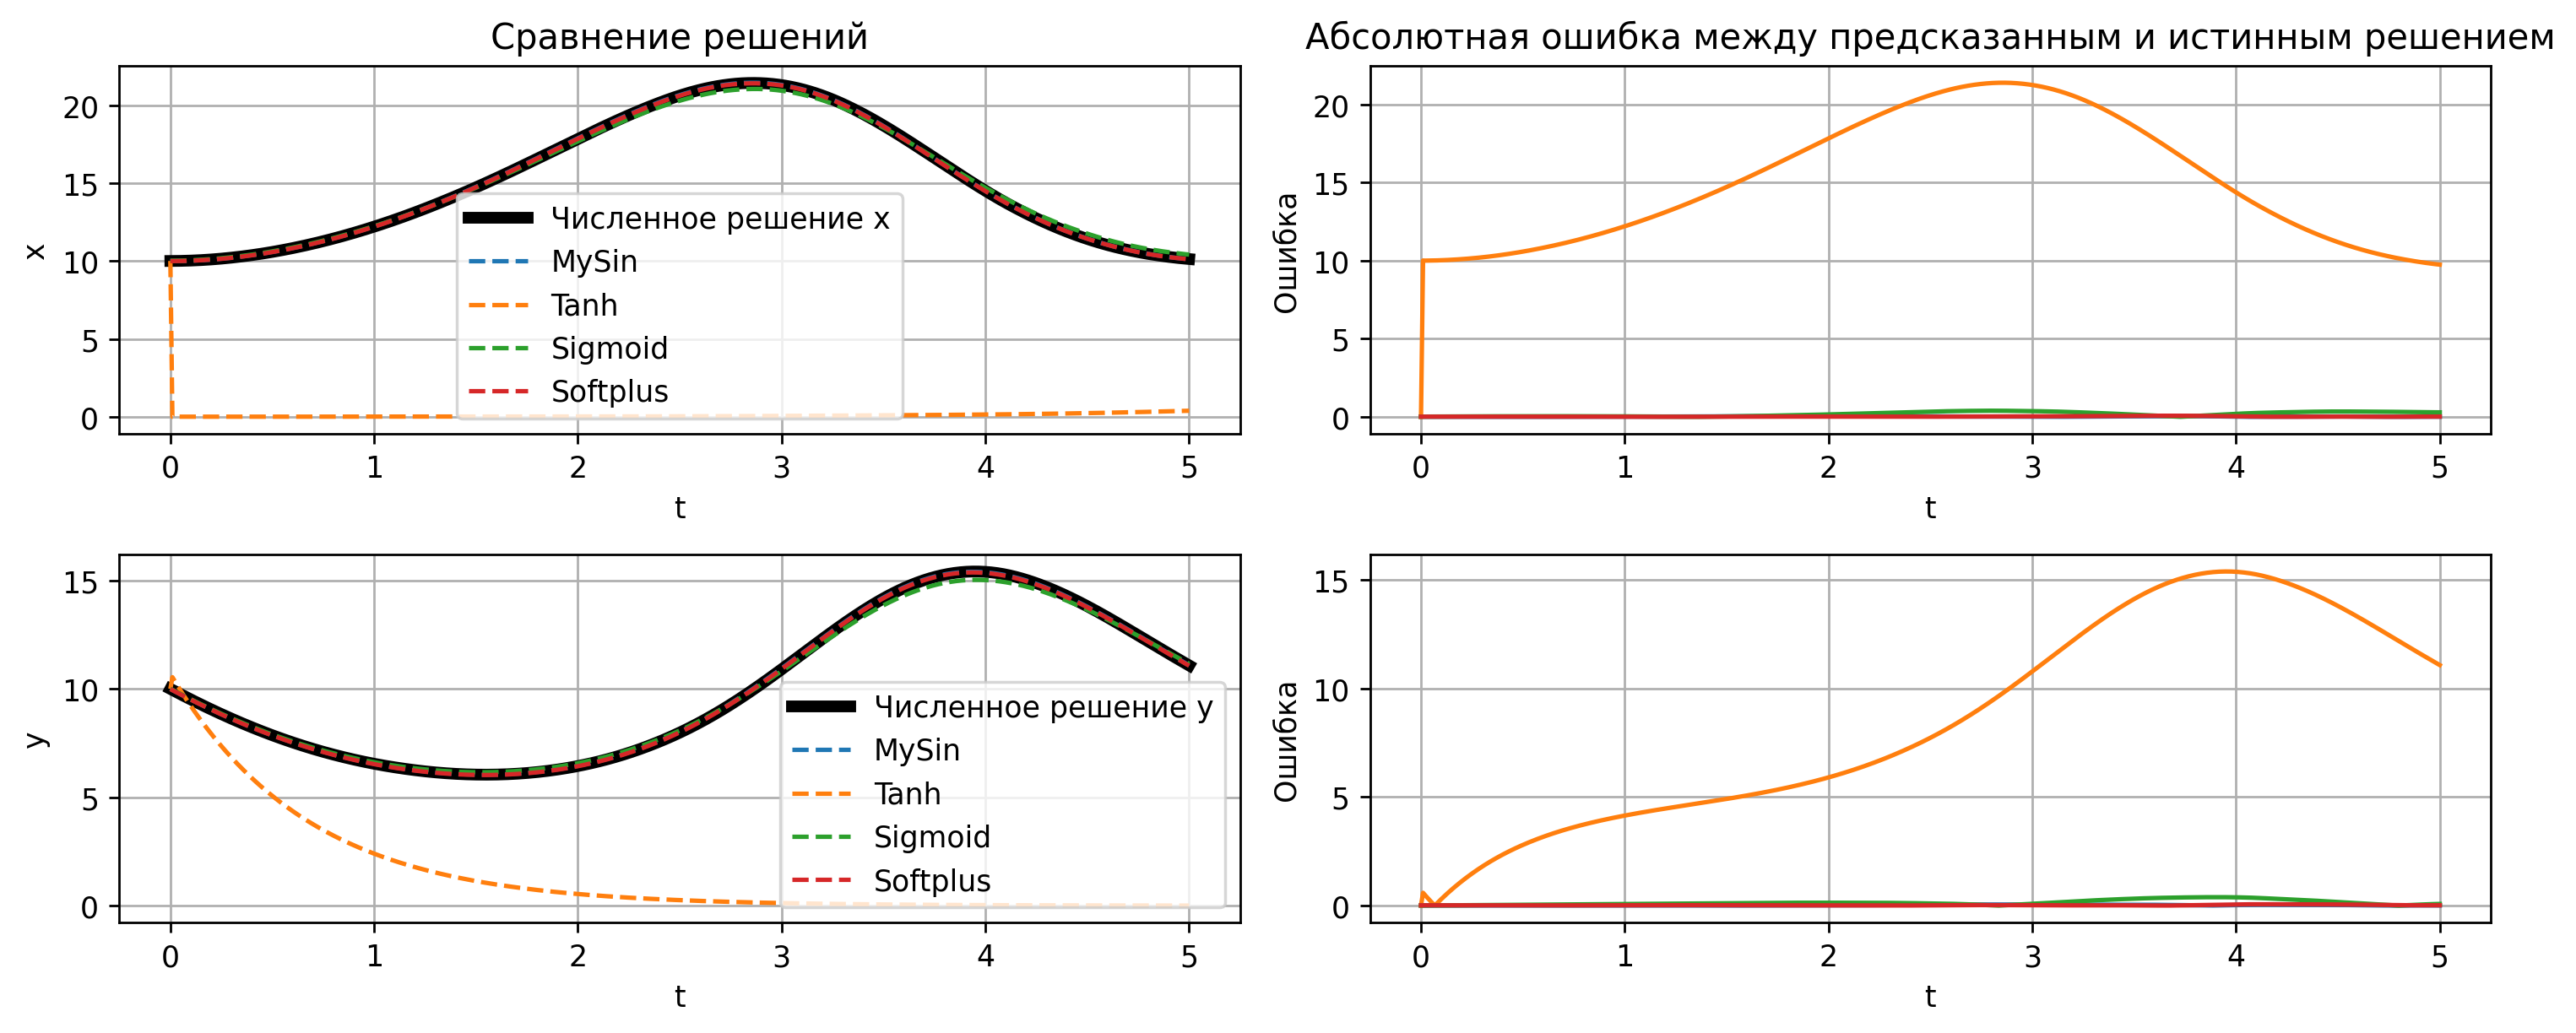

In [ ]:
# Отрисовка результатов

plt.figure(figsize=(12, 5), dpi=250)

# Сравнение по x
plt.subplot(2, 2, 1)
plt.plot(t_plot, x_ref, label='Численное решение x', linewidth = 4, color='k')

for i in range(len(pred_funcs)):
  plt.plot(t_plot, pred_funcs[i][0], '--', label=str(activation_functions[i]).split('.')[-1].replace("'>", ""))

plt.xlabel('t')
plt.ylabel('x')
plt.title('Сравнение решений')
plt.legend()
plt.grid(True)

# График абсолютной ошибки по x
plt.subplot(2, 2, 2)
for i in range(len(errors)):
  plt.plot(t_plot, errors[i][0], label=str(activation_functions[i]).split('.')[-1].replace("'>", ""))
plt.xlabel('t')
plt.ylabel('Ошибка')
plt.title('Абсолютная ошибка между предсказанным и истинным решением')
plt.grid(True)

# Сравнение по y
plt.subplot(2, 2, 3)
plt.plot(t_plot, y_ref, label='Численное решение y', linewidth = 4, color='k')

for i in range(len(pred_funcs)):
  plt.plot(t_plot, pred_funcs[i][1], '--', label=str(activation_functions[i]).split('.')[-1].replace("'>", ""))

plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.grid(True)

# График абсолютной ошибки по y
plt.subplot(2, 2, 4)
for i in range(len(errors)):
  plt.plot(t_plot, errors[i][1], label=str(activation_functions[i]).split('.')[-1].replace("'>", ""))
plt.xlabel('t')
plt.ylabel('Ошибка')
plt.grid(True)

plt.tight_layout()
plt.show()